In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

device = "cpu"

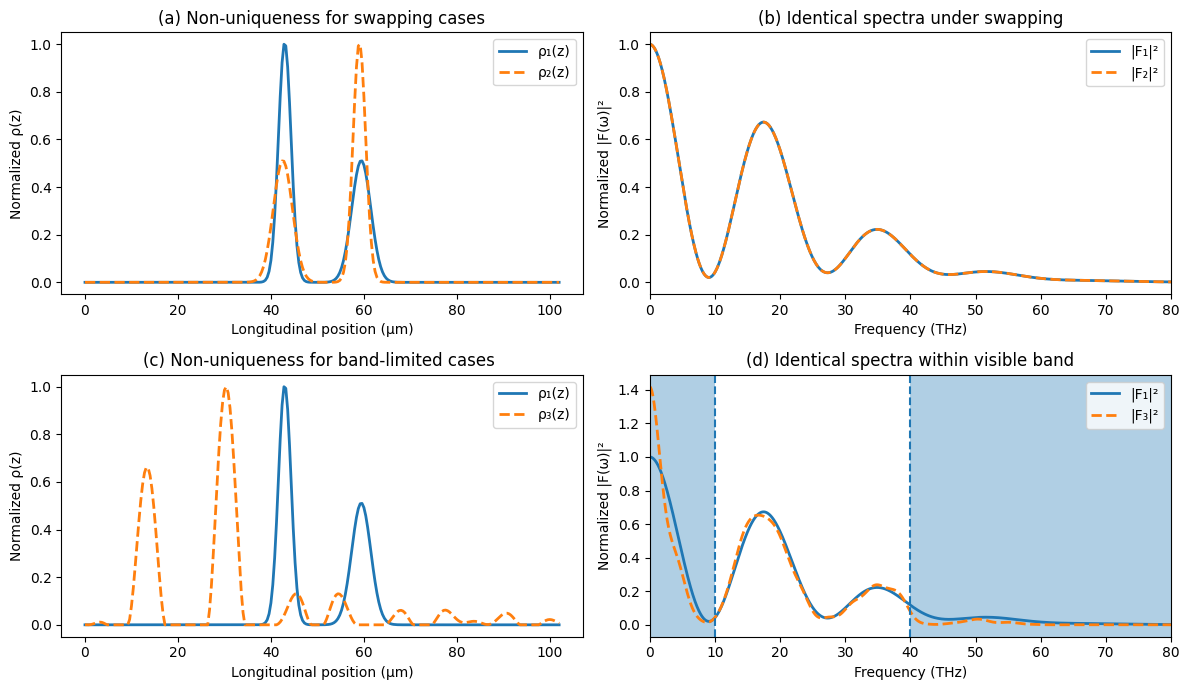

Mean in-band difference: 1.8661e-02


In [2]:
# Figure 1

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# ========= 读取样本 =========
input_folder = "./generated_beam_profile/Figure/"
files = [f for f in os.listdir(input_folder) if f.endswith(".pt")]
fname = files[2]
# fname = files[50]

sample = torch.load(os.path.join(input_folder, fname),weights_only=False)
x_um = sample["x_um"].cpu().numpy()
rho1 = sample["Intensity"].cpu().numpy().astype(np.float64)

# 面积归一（更物理）
rho1 = np.clip(rho1, 0, None)
rho1 = rho1 / np.trapezoid(rho1, x_um)

# ========= intrinsic non-uniqueness =========
rho2 = np.flip(rho1)

# ========= 频域工具 =========
def k_to_THz(k):
    c = 3e8
    k_m = k * 1e6
    return (c * k_m / (2*np.pi)) / 1e12

def fft_with_pad(rho, x_um, pad_factor=50):
    dx = x_um[1] - x_um[0]
    N = len(rho)
    Np = pad_factor * N
    rho_pad = np.zeros(Np)
    rho_pad[:N] = rho
    R = np.fft.fft(rho_pad)
    k = np.fft.fftfreq(Np, d=dx) * 2*np.pi
    f = k_to_THz(k)
    return R, f, Np, N

def ifft_crop(R, N):
    return np.fft.ifft(R).real[:N]

# ========= band-limited GS 生成 alt profile =========
def gs_band_limited_alt_profile(
    x_um,
    rho_ref,
    f_low=10,
    f_high=40,
    pad_factor=50,
    n_iter=800,
    seed=3,
):
    rng = np.random.default_rng(seed)

    R_ref, f_THz, Np, N = fft_with_pad(rho_ref, x_um, pad_factor)
    A_target = np.abs(R_ref)

    band_mask = (np.abs(f_THz) >= f_low) & (np.abs(f_THz) <= f_high)

    phase = rng.uniform(0, 2*np.pi, size=R_ref.shape)
    R = A_target * np.exp(1j * phase)

    for _ in range(n_iter):
        rho = ifft_crop(R, N)
        rho = np.clip(rho, 0, None)

        # 轻微平滑
        rho = np.convolve(rho, np.ones(5)/5, mode='same')

        area = np.trapezoid(rho, x_um)
        if area > 0:
            rho = rho / area

        R_new, _, _, _ = fft_with_pad(rho, x_um, pad_factor)
        phase_new = np.angle(R_new)

        R_new[band_mask] = A_target[band_mask] * np.exp(1j * phase_new[band_mask])
        R = R_new

    rho_out = ifft_crop(R, N)
    rho_out = np.clip(rho_out, 0, None)
    area = np.trapezoid(rho_out, x_um)
    if area > 0:
        rho_out = rho_out / area

    return rho_out

f_low, f_high = 10, 40
rho3 = gs_band_limited_alt_profile(x_um, rho1, f_low, f_high)

# ========= 计算频谱 =========
def get_positive_spectrum(rho):
    R, f_full, _, _ = fft_with_pad(rho, x_um)
    mask = f_full >= 0
    f = f_full[mask]
    F2 = np.abs(R[mask])**2
    F2 = F2 / np.max(F2)
    return f, F2

f1, F2_1 = get_positive_spectrum(rho1)
f2, F2_2 = get_positive_spectrum(rho2)
f3, F2_3 = get_positive_spectrum(rho3)

# ========= band 内最优缩放 =========
band_mask = (f1 >= f_low) & (f1 <= f_high)
alpha = np.sum(F2_1[band_mask] * F2_3[band_mask]) / np.sum(F2_3[band_mask]**2)
F2_3_scaled = F2_3 * alpha

# ========= 作图 =========
fig, axes = plt.subplots(2, 2, figsize=(12, 7))

# (A) intrinsic profiles
axes[0,0].plot(x_um, rho1/np.max(rho1), linewidth=2, label="ρ₁(z)")
axes[0,0].plot(x_um, rho2/np.max(rho2), linestyle="--", linewidth=2, label="ρ₂(z)")
axes[0,0].set_title("(a) Non-uniqueness for swapping cases")
axes[0,0].set_xlabel("Longitudinal position (μm)")
axes[0,0].set_ylabel("Normalized ρ(z)")
axes[0,0].legend()

# (B) identical spectra (swap)
axes[0,1].plot(f1, F2_1, linewidth=2, label="|F₁|²")
axes[0,1].plot(f2, F2_2, linestyle="--", linewidth=2, label="|F₂|²")
axes[0,1].set_xlim(0, 80)
axes[0,1].set_title("(b) Identical spectra under swapping")
axes[0,1].set_xlabel("Frequency (THz)")
axes[0,1].set_ylabel("Normalized |F(ω)|²")
axes[0,1].legend()

# (C) band-limited ambiguity
axes[1,0].plot(x_um, rho1/np.max(rho1), linewidth=2, label="ρ₁(z)")
axes[1,0].plot(x_um, rho3/np.max(rho3), linestyle="--", linewidth=2, label="ρ₃(z)")
axes[1,0].set_title("(c) Non-uniqueness for band-limited cases ")
axes[1,0].set_xlabel("Longitudinal position (μm)")
axes[1,0].set_ylabel("Normalized ρ(z)")
axes[1,0].legend()

# (D) in-band indistinguishable
axes[1,1].plot(f1, F2_1, linewidth=2, label="|F₁|²")
axes[1,1].plot(f1, F2_3_scaled, linestyle="--", linewidth=2, label="|F₃|²")

axes[1,1].axvspan(0, f_low, alpha=0.35)
axes[1,1].axvspan(f_high, 80, alpha=0.35)
axes[1,1].axvline(f_low, linestyle="--")
axes[1,1].axvline(f_high, linestyle="--")

axes[1,1].set_xlim(0, 80)
axes[1,1].set_title("(d) Identical spectra within visible band")
axes[1,1].set_xlabel("Frequency (THz)")
axes[1,1].set_ylabel("Normalized |F(ω)|²")
axes[1,1].legend()

plt.tight_layout()
plt.show()

# ========= 误差检查 =========
band_err = np.mean(np.abs(F2_1[band_mask] - F2_3_scaled[band_mask]))
print(f"Mean in-band difference: {band_err:.4e}")


In [3]:
# GS code

import torch.nn.functional as F
import torch.fft as fft


## start: torch
def _smooth_1d(x: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
    """
    Convolve 1D tensor x with a 1D kernel (both on same device).
    Reflect padding to avoid edge artifacts.
    """
    x = x.view(1, 1, -1)  # [B,C,L]
    k = kernel.view(1, 1, -1)
    pad = (k.shape[-1] - 1) // 2
    x_pad = F.pad(x, (pad, pad), mode="reflect")
    y = F.conv1d(x_pad, k)
    return y.view(-1)

def get_smoothing_kernel(device="cpu"):
    k = torch.tensor([1., 4., 6., 4., 1.], device=device)
    k = k / k.sum()
    return k

    
def gerchberg_saxton_1d_torch(
    I_meas: torch.Tensor,
    n_iters: int = 500,
    support_mask: torch.Tensor = None,
    smooth: bool = True,
    device: str = "cpu",
) -> torch.Tensor:
    """
    1D Gerchberg–Saxton phase retrieval. 
    Optionally applies a mild smoothing after each iteration.

    I_meas: measured spectrum (|FFT[rho_true]|^2), shape [N]
    support_mask: optional 0/1 mask in z-domain, shape [N]
    
    Returns
    --------
    rho_recon(z)
    """
    device = torch.device(device)
    I_meas = I_meas.to(device)
    N = I_meas.numel()

    # magnitude in frequency domain
    mag_meas = torch.sqrt(torch.clamp(I_meas, min=0.0))

    # random positive real initial guess in z
    rho = torch.rand(N, device=device)
    rho = rho / rho.sum()
    
    kernel = get_smoothing_kernel(device) if smooth else None

    for _ in range(n_iters):
        # forward: z -> k
        F = fft.fft(rho)

        # impose measured magnitude, keep current phase
        phase = torch.exp(1j * torch.angle(F))
        F_new = mag_meas * phase

        # inverse: k -> z
        rho_new = fft.ifft(F_new).real

        # real-space constraints: positivity + optional support
        rho_new = torch.clamp(rho_new, min=0.0)
        if support_mask is not None:
            rho_new = rho_new * support_mask.to(device)
        
        # smoothing (optional)
        if kernel is not None:
            rho_new = _smooth_1d(rho_new, kernel)

        # renormalize total charge
        s = rho_new.sum()
        if s > 0:
            rho_new = rho_new / s

        rho = rho_new

    return rho


##-- start: numpy
def get_smoothing_kernel_numpy():
    k = np.array([1., 4., 6., 4., 1.], dtype=np.float64)
    k = k / k.sum()
    return k


def _smooth_1d_numpy(x: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    1D convolution with reflect padding, analogous to _smooth_1d (Torch).
    """
    pad = (kernel.size - 1) // 2
    x_pad = np.pad(x, pad_width=pad, mode="reflect")
    y = np.convolve(x_pad, kernel, mode="valid")
    return y

def gerchberg_saxton_1d_numpy(
    I_meas_np: np.ndarray,
    n_iters: int = 500,
    support_mask_np: np.ndarray | None = None,
    smooth: bool = True,
    seed: int | None = None,
) -> np.ndarray:
    """
    1D Gerchberg–Saxton phase retrieval (NumPy backend).
    Same logic as gerchberg_saxton_1d_torch but in NumPy.
    """
    I_meas_np = np.asarray(I_meas_np, dtype=np.float64)
    N = I_meas_np.size
    mag_meas = np.sqrt(np.clip(I_meas_np, 0.0, None))

    if support_mask_np is not None:
        support_mask_np = np.asarray(support_mask_np, dtype=np.float64)

    rng = np.random.default_rng(seed)

    # random positive real initial guess
    rho = rng.random(N)
    rho /= rho.sum()

    kernel = get_smoothing_kernel_numpy() if smooth else None

    for _ in range(n_iters):
        # forward: z -> k
        Fk = np.fft.fft(rho)

        # impose measured magnitude, keep current phase
        phase = np.exp(1j * np.angle(Fk))
        F_new = mag_meas * phase

        # inverse: k -> z
        rho_new = np.fft.ifft(F_new).real

        # constraints in real space
        rho_new = np.maximum(rho_new, 0.0)
        if support_mask_np is not None:
            rho_new *= support_mask_np

        if kernel is not None and kernel.size > 1:
            rho_new = _smooth_1d_numpy(rho_new, kernel)

        s = rho_new.sum()
        if s > 0:
            rho_new /= s

        rho = rho_new

    return rho
##--- end: numpy

def forward_spectrum_fft(rho: torch.Tensor):
    """
    Forward model:
        rho(z) -> I(k) = |FFT[rho]|^2
    """
    Fk = torch.fft.fft(rho)
    I = torch.abs(Fk) ** 2
    return I, Fk

## choose backend
def gerchberg_saxton_multistart(
    I_meas: torch.Tensor,
    n_iters: int,
    support_mask: torch.Tensor = None,
    n_restarts: int = 8,
    backend: str = "torch",   # "torch" or "numpy"
    device: str = "cpu",
    seed = None,
) -> torch.Tensor:
    """
    Run GS multiple times with different random initializations and
    return the reconstruction whose spectrum best matches I_meas.

    backend:
        - "torch"  : use gerchberg_saxton_1d_torch
        - "numpy"  : use gerchberg_saxton_1d_numpy
                     (converted back to torch at the end)
    """
    backend = backend.lower()
    device = torch.device(device)
    
    if seed is not None:
        torch.manual_seed(seed)

    if backend == "torch":
         # torch backend
        best_rho = None
        best_loss = float("inf")
        dev = torch.device(device)

        for r in range(n_restarts):
            # different seed per restart for reproducibility
            # torch.manual_seed(r)
            rho = gerchberg_saxton_1d_torch(
                I_meas=I_meas,
                n_iters=n_iters,
                support_mask=support_mask,
                smooth=True,
                device=device,
            )

            I_rec, _ = forward_spectrum_fft(rho)
            loss = torch.mean(
                (torch.log(I_rec + 1e-12) - torch.log(I_meas.to(device) + 1e-12))**2
            )
            if loss.item() < best_loss:
                best_loss = float(loss.item())
                best_rho = rho.detach()

        print(f"[GS-Torch-{dev.type}] best spectral loss over {n_restarts} restarts: {best_loss:.3e}")
        return best_rho.to(device)

    elif backend == "numpy":
        # numpy backend
        I_meas_np = I_meas.detach().cpu().numpy()
        support_np = None if support_mask is None else support_mask.detach().cpu().numpy()

        best_rho_np = None
        best_loss = np.inf

        for r in range(n_restarts):
            rho_np = gerchberg_saxton_1d_numpy(
                I_meas_np=I_meas_np,
                n_iters=n_iters,
                support_mask_np=support_np,
                smooth=True,
                seed=r,
            )

            # compute spectrum and log-MSE in numpy
            Fk = np.fft.fft(rho_np)
            I_rec_np = np.abs(Fk)**2
            loss = np.mean(
                (np.log(I_rec_np + 1e-12) - np.log(I_meas_np + 1e-12))**2
            )

            if loss < best_loss:
                best_loss = float(loss)
                best_rho_np = rho_np.copy()

        print(f"[GS-NumPy] best spectral loss over {n_restarts} restarts: {best_loss:.3e}")

        # convert back to torch for downstream code
        best_rho_torch = torch.from_numpy(best_rho_np).to(device, dtype=I_meas.dtype)
        return best_rho_torch

    else:
        raise ValueError("backend must be 'torch' or 'numpy'")


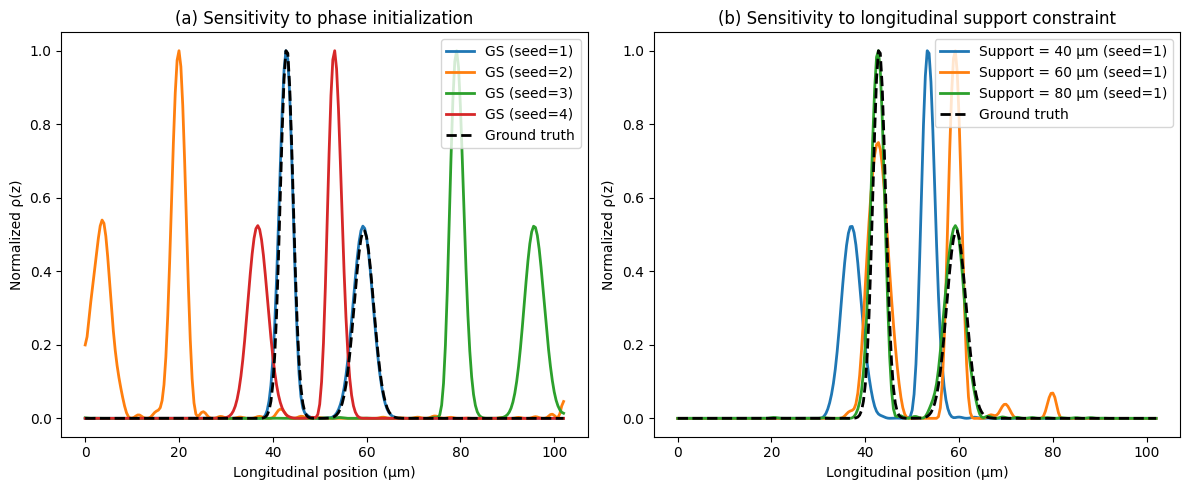

In [4]:
# Figure 2

# =========================================
# 1) Ground truth
# =========================================
rho_true_np = np.array(rho1, dtype=np.float64)
rho_true_np = np.clip(rho_true_np, 0, None)
rho_true_np = rho_true_np / np.sum(rho_true_np)
rho_true = torch.tensor(rho_true_np, dtype=torch.float32, device=device)

# =========================================
# 2) Full-bandwidth spectrum
# =========================================
I_meas, _ = forward_spectrum_fft(rho_true)
I_meas = I_meas.real
I_meas = I_meas / torch.max(I_meas)

# =========================================
# 3) (A) Initialization sensitivity
# =========================================
init_seeds = [1, 2, 3, 4]
recon_init = []

for s in init_seeds:
    torch.manual_seed(s)

    rho_rec = gerchberg_saxton_1d_torch(
        I_meas=I_meas,
        n_iters=400,
        support_mask=None,
        smooth=True,
        device=device,
    )

    r = rho_rec.detach().cpu().numpy()
    r = np.clip(r, 0, None)
    r = r / r.max() if r.max() > 0 else r
    recon_init.append((s, r))

# =========================================
# 4) (B) Support sensitivity (no alignment)
# =========================================
support_widths = [40, 60, 80]
support_seed = 1
recon_support = []

center = np.mean(x_um)

for w in support_widths:
    mask = (np.abs(x_um - center) <= w/2).astype(np.float32)
    support_mask = torch.tensor(mask, dtype=torch.float32, device=device)

    torch.manual_seed(support_seed)

    rho_rec = gerchberg_saxton_1d_torch(
        I_meas=I_meas,
        n_iters=400,
        support_mask=support_mask,
        smooth=True,
        device=device,
    )

    r = rho_rec.detach().cpu().numpy()
    r = np.clip(r, 0, None)
    r = r / r.max() if r.max() > 0 else r
    recon_support.append((w, r))

# =========================================
# 5) Plot
# =========================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---------- (A) Initialization sensitivity ----------
for s, r in recon_init:
    axes[0].plot(x_um, r, linewidth=2, label=f"GS (seed={s})")

axes[0].plot(
    x_um,
    rho_true_np / rho_true_np.max(),
    "k--",
    linewidth=2,
    label="Ground truth"
)

axes[0].set_title("(a) Sensitivity to phase initialization")
axes[0].set_xlabel("Longitudinal position (μm)")
axes[0].set_ylabel("Normalized ρ(z)")
axes[0].legend(loc="upper right")

# ---------- (B) Support sensitivity ----------
for w, r in recon_support:
    axes[1].plot(x_um, r, linewidth=2,
                 label=f"Support = {w} μm (seed={support_seed})")

axes[1].plot(
    x_um,
    rho_true_np / rho_true_np.max(),
    "k--",
    linewidth=2,
    label="Ground truth"
)

axes[1].set_title("(b) Sensitivity to longitudinal support constraint")
axes[1].set_xlabel("Longitudinal position (μm)")
axes[1].set_ylabel("Normalized ρ(z)")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()


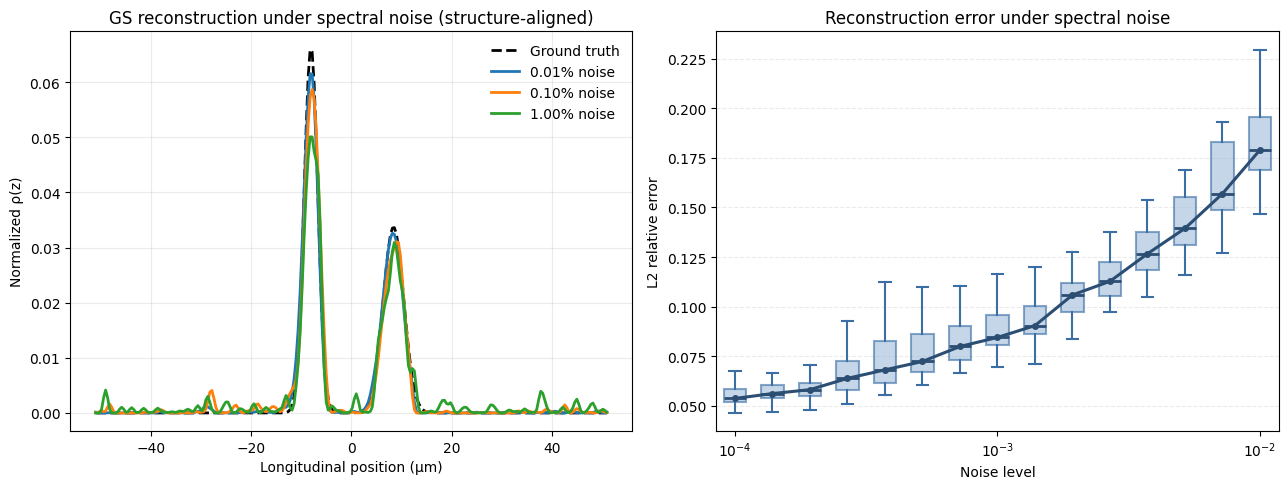

In [ ]:
# =========================================
# GS Noise Robustness (Peak-weighted metric)
# LEFT: representative reconstructions
# RIGHT: structure-preservation error vs noise
# (structure-safe alignment for double-peaks)
# =========================================

import numpy as np
import torch
import matplotlib.pyplot as plt

# NOTE:
# This script assumes you already have:
#   - rho1 (ground-truth profile samples, same length as x_um)
#   - x_um (position axis in micrometers, 1D numpy array)
#   - device (torch.device)
#   - forward_spectrum_fft(rho_true: torch.Tensor) -> (I, phase/aux)
#   - gerchberg_saxton_1d_torch(I_meas, n_iters, support_mask, smooth, device) -> rho_rec (torch.Tensor)

# =========================================
# Ground truth preparation
# =========================================

rho_true_np = np.array(rho1, dtype=np.float64)
rho_true_np = np.clip(rho_true_np, 0, None)
rho_true_np = rho_true_np / (np.sum(rho_true_np) + 1e-12)

rho_true = torch.tensor(rho_true_np, dtype=torch.float32, device=device)
rho_true_norm = rho_true_np  # area-normalized ground truth

I_clean, _ = forward_spectrum_fft(rho_true)
I_clean = I_clean.real
I_clean = I_clean / (torch.max(I_clean) + 1e-12)

I_scale = torch.max(I_clean) + 1e-12

# Support mask (60 um window centered at mean(x_um))
center = float(np.mean(x_um))
mask = (np.abs(x_um - center) <= 100 / 2).astype(np.float32)
support_mask = torch.tensor(mask, dtype=torch.float32, device=device)

dx = float(x_um[1] - x_um[0])

# =========================================
# Structure-safe alignment (cross-correlation based)
#   - fixes peak swap / inversion cases for double-peaks
# =========================================

# Peak-weighting: emphasize where ground truth is strong
weight = rho_true_norm / (np.max(rho_true_norm) + 1e-12)

def weighted_error(pred):
    """Peak-weighted relative L2 error."""
    pred = np.asarray(pred, dtype=np.float64)
    diff = weight * (pred - rho_true_norm)
    num = np.linalg.norm(diff)
    den = np.linalg.norm(weight * rho_true_norm) + 1e-12
    return num / den

def _best_shift_alignment(profile, reference):
    """
    Find best circular shift to align 'profile' to 'reference' using cross-correlation.
    Returns aligned profile and shift (in samples), where aligned = roll(profile, -shift).
    """
    profile = np.asarray(profile, dtype=np.float64)
    reference = np.asarray(reference, dtype=np.float64)

    # Remove DC component to reduce bias from broad baselines
    p = profile - np.mean(profile)
    r = reference - np.mean(reference)

    corr = np.correlate(p, r, mode="full")
    shift = int(np.argmax(corr) - (len(profile) - 1))
    aligned = np.roll(profile, -shift)
    return aligned, shift

def align_with_orientation(profile):
    """
    Try:
      (1) normal orientation + best shift
      (2) flipped orientation + best shift
    Choose the one with smaller weighted_error.

    This is robust to "double-peak swap" and global inversion.
    """
    prof = np.asarray(profile, dtype=np.float64)
    prof = np.clip(prof, 0, None)
    prof = prof / (np.sum(prof) + 1e-12)

    # --- normal ---
    aligned_n, _ = _best_shift_alignment(prof, rho_true_norm)
    err_n = weighted_error(aligned_n)

    # --- flipped ---
    prof_f = prof[::-1]
    aligned_f, _ = _best_shift_alignment(prof_f, rho_true_norm)
    err_f = weighted_error(aligned_f)

    return aligned_f if err_f < err_n else aligned_n

# x-axis for plotting (just center the axis for readability)
x0_um = x_um - np.mean(x_um)

# =========================================
# LEFT PANEL — Representative curves
# =========================================

rep_levels = [1e-4, 1e-3, 1e-2]
rep_results = []

for nl in rep_levels:
    torch.manual_seed(1)
    noise = nl * torch.randn_like(I_clean)

    I_noisy = I_clean + noise
    I_noisy = torch.clamp(I_noisy, min=0.0)
    I_noisy = I_noisy / I_scale

    torch.manual_seed(2)
    rho_rec = gerchberg_saxton_1d_torch(
        I_meas=I_noisy,
        n_iters=2000,
        support_mask=support_mask,
        smooth=True,
        device=device,
    )

    r = rho_rec.detach().cpu().numpy()
    r = np.clip(r, 0, None)
    r = r / (np.sum(r) + 1e-12)

    r_aligned = align_with_orientation(r)
    rep_results.append((nl, r_aligned))

# =========================================
# RIGHT PANEL — Statistical scan
# =========================================

noise_levels = np.logspace(-4, -2, 15)
n_trials = 50
all_errors = []

for nl in noise_levels:
    trial_errors = []

    for seed in range(n_trials):
        torch.manual_seed(seed)
        noise = nl * torch.randn_like(I_clean)

        I_noisy = I_clean + noise
        I_noisy = torch.clamp(I_noisy, min=0.0)
        I_noisy = I_noisy / I_scale

        # Keep GS init deterministic across trials if you want (or change per seed)
        torch.manual_seed(100)
        rho_rec = gerchberg_saxton_1d_torch(
            I_meas=I_noisy,
            n_iters=2000,
            support_mask=support_mask,
            smooth=True,
            device=device,
        )

        r = rho_rec.detach().cpu().numpy()
        r = np.clip(r, 0, None)
        r = r / (np.sum(r) + 1e-12)

        r_aligned = align_with_orientation(r)
        err = weighted_error(r_aligned)
        trial_errors.append(err)

    all_errors.append(trial_errors)

# =========================================
# Plot
# =========================================

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# ---- LEFT ----
ax1 = axes[0]
ax1.plot(x0_um, rho_true_norm, "k--", linewidth=2, label="Ground truth")

for nl, r in rep_results:
    ax1.plot(x0_um, r, linewidth=2, label=f"{nl*100:.2f}% noise")

ax1.set_xlabel("Longitudinal position (μm)")
ax1.set_ylabel("Normalized ρ(z)")
ax1.set_title("GS reconstruction under spectral noise (structure-aligned)")
ax1.legend(frameon=False)
ax1.grid(alpha=0.25)

# ---- RIGHT ----
box_main = "#3A6EA5"
box_fill = "#9DBBD9"
median_color = "#2C4E73"

ax2 = axes[1]
idx = np.arange(len(noise_levels))

box = ax2.boxplot(
    all_errors,
    positions=idx,
    widths=0.6,
    patch_artist=True,
    showfliers=False,
    medianprops=dict(color=median_color, linewidth=2),
    whiskerprops=dict(color=box_main, linewidth=1.5),
    capprops=dict(color=box_main, linewidth=1.5),
    boxprops=dict(color=box_main, linewidth=1.5),
)

for patch in box["boxes"]:
    patch.set_facecolor(box_fill)
    patch.set_alpha(0.6)

medians = [np.median(e) for e in all_errors]
ax2.plot(idx, medians, color=median_color, linewidth=2.2, marker="o", markersize=4)

ax2.set_xlabel("Noise level")
ax2.set_ylabel("L2 relative error")
ax2.set_title("Reconstruction error under spectral noise")

ax2.set_xticks([0, 7, 14])
ax2.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"])

ax2.grid(axis="y", linestyle="--", alpha=0.25)

plt.tight_layout()
plt.show()


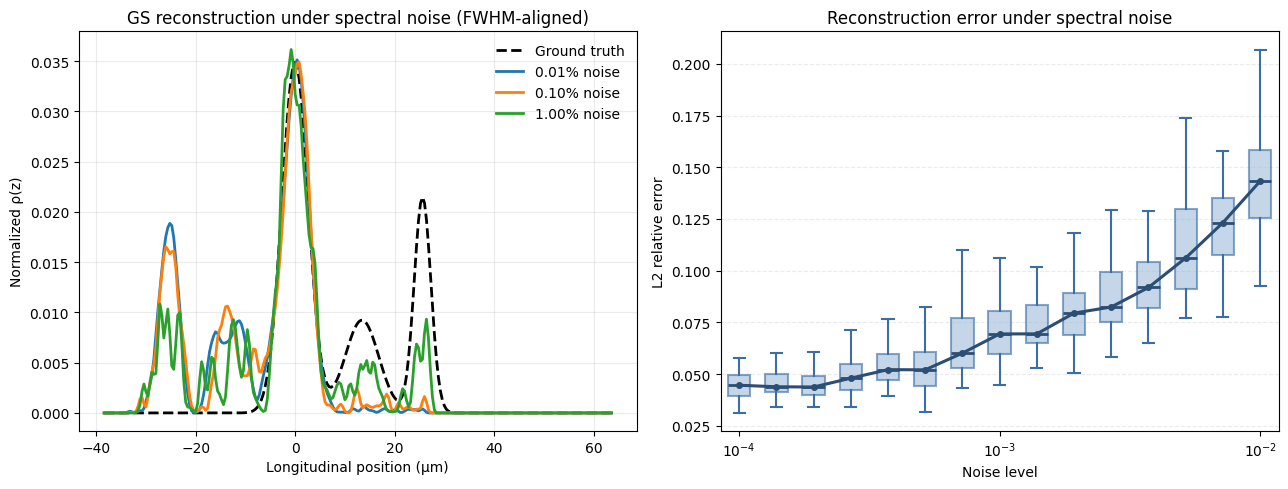

In [11]:
# =========================================
# GS Noise Robustness (Peak-weighted metric)
# LEFT: representative reconstructions
# RIGHT: structure-preservation error vs noise
# =========================================

# =========================================
# Ground truth preparation
# =========================================

rho_true_np = np.array(rho1, dtype=np.float64)
rho_true_np = np.clip(rho_true_np, 0, None)
rho_true_np = rho_true_np / np.sum(rho_true_np)

rho_true = torch.tensor(rho_true_np, dtype=torch.float32, device=device)
rho_true_norm = rho_true_np
rho_true_norm_max = rho_true_np / np.max(rho_true_np)

I_clean, _ = forward_spectrum_fft(rho_true)
I_clean = I_clean.real
I_clean = I_clean / torch.max(I_clean)

I_scale = torch.max(I_clean)

center = np.mean(x_um)
mask = (np.abs(x_um - center) <= 60 / 2).astype(np.float32)
support_mask = torch.tensor(mask, dtype=torch.float32, device=device)

dx = float(x_um[1] - x_um[0])

# =========================================
# FWHM alignment
# =========================================

def fwhm_center(profile, x):
    if np.max(profile) <= 0:
        return np.mean(x)

    p = gaussian_filter1d(profile, sigma=1)
    peak_idx = np.argmax(p)
    peak_val = p[peak_idx]
    half_val = 0.5 * peak_val

    left_idx = peak_idx
    while left_idx > 0 and p[left_idx] > half_val:
        left_idx -= 1

    right_idx = peak_idx
    while right_idx < len(p) - 1 and p[right_idx] > half_val:
        right_idx += 1

    return 0.5 * (x[left_idx] + x[right_idx])

c_true = fwhm_center(rho_true_norm_max, x_um)

def align_by_fwhm(profile):
    profile_max = profile / np.max(profile) if np.max(profile) > 0 else profile
    c = fwhm_center(profile_max, x_um)
    shift_pts = int(np.round((c - c_true) / dx))
    return np.roll(profile, -shift_pts)

x0_um = x_um - c_true

# =========================================
# LEFT PANEL — Representative curves（不变）
# =========================================

rep_levels = [1e-4, 1e-3, 1e-2]
rep_results = []

for nl in rep_levels:

    torch.manual_seed(0)
    noise = nl * torch.randn_like(I_clean)

    I_noisy = I_clean + noise
    I_noisy = torch.clamp(I_noisy, min=0.0)
    I_noisy = I_noisy / I_scale

    torch.manual_seed(1)
    rho_rec = gerchberg_saxton_1d_torch(
        I_meas=I_noisy,
        n_iters=2000,
        support_mask=support_mask,
        smooth=True,
        device=device,
    )

    r = rho_rec.detach().cpu().numpy()
    r = np.clip(r, 0, None)
    r = r / np.sum(r)

    r_aligned = align_by_fwhm(r)
    rep_results.append((nl, r_aligned))

# =========================================
# NEW ERROR METRIC（与CNN一致）
# =========================================

weight = rho_true_norm
weight = weight / np.max(weight)

def weighted_error(pred):
    diff = weight * (pred - rho_true_norm)
    num = np.linalg.norm(diff)
    den = np.linalg.norm(weight * rho_true_norm)
    return num / den

# =========================================
# RIGHT PANEL — Statistical scan
# =========================================

noise_levels = np.logspace(-4, -2, 15)
n_trials = 50
all_errors = []

for nl in noise_levels:

    trial_errors = []

    for seed in range(n_trials):

        torch.manual_seed(seed)
        noise = nl * torch.randn_like(I_clean)

        I_noisy = I_clean + noise
        I_noisy = torch.clamp(I_noisy, min=0.0)
        I_noisy = I_noisy / I_scale

        torch.manual_seed(100)
        rho_rec = gerchberg_saxton_1d_torch(
            I_meas=I_noisy,
            n_iters=2000,
            support_mask=support_mask,
            smooth=True,
            device=device,
        )

        r = rho_rec.detach().cpu().numpy()
        r = np.clip(r, 0, None)
        r = r / np.sum(r)

        r_aligned = align_by_fwhm(r)

        err = weighted_error(r_aligned)
        trial_errors.append(err)

    all_errors.append(trial_errors)

# =========================================
# Plot
# =========================================

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# ---- LEFT ----
ax1 = axes[0]

ax1.plot(x0_um, rho_true_norm, "k--", linewidth=2, label="Ground truth")

for nl, r in rep_results:
    ax1.plot(x0_um, r, linewidth=2, label=f"{nl*100:.2f}% noise")

ax1.set_xlabel("Longitudinal position (μm)")
ax1.set_ylabel("Normalized ρ(z)")
ax1.set_title("GS reconstruction under spectral noise (FWHM-aligned)")
ax1.legend(frameon=False)
ax1.grid(alpha=0.25)

# ---- RIGHT（风格与CNN一致）----
box_main = "#3A6EA5"
box_fill = "#9DBBD9"
median_color = "#2C4E73"

ax2 = axes[1]

idx = np.arange(len(noise_levels))

box = ax2.boxplot(
    all_errors,
    positions=idx,
    widths=0.6,
    patch_artist=True,
    showfliers=False,
    medianprops=dict(color=median_color, linewidth=2),
    whiskerprops=dict(color=box_main, linewidth=1.5),
    capprops=dict(color=box_main, linewidth=1.5),
    boxprops=dict(color=box_main, linewidth=1.5),
)

for patch in box["boxes"]:
    patch.set_facecolor(box_fill)
    patch.set_alpha(0.6)

medians = [np.median(e) for e in all_errors]
ax2.plot(idx, medians, color=median_color, linewidth=2.2, marker="o", markersize=4)

ax2.set_xlabel("Noise level")
ax2.set_ylabel("L2 relative error")
ax2.set_title("Reconstruction error under spectral noise")

ax2.set_xticks([0, 7, 14])
ax2.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"])

ax2.grid(axis="y", linestyle="--", alpha=0.25)

plt.tight_layout()
plt.show()


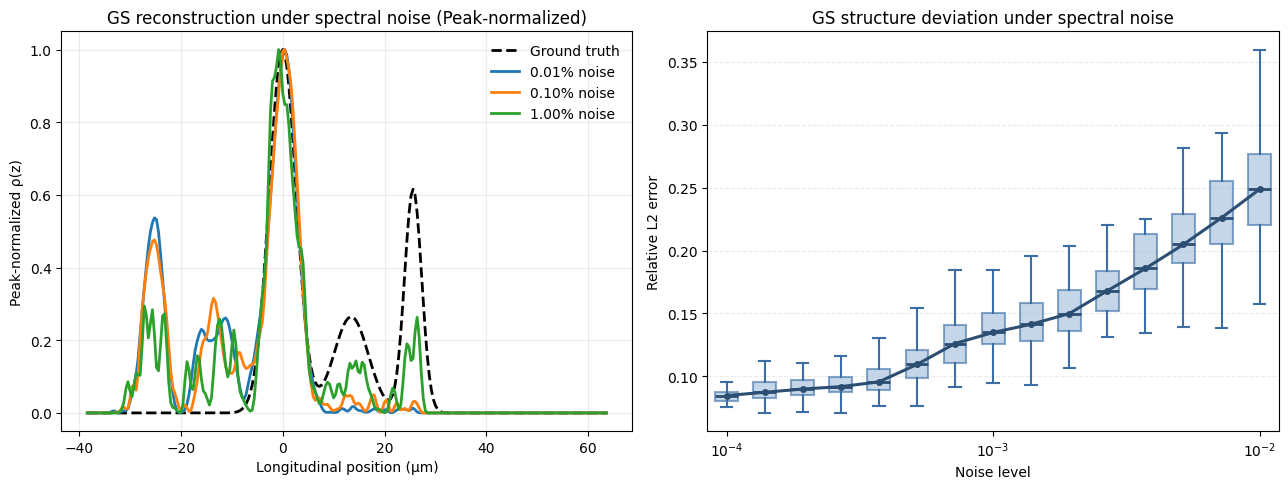

In [7]:
# =========================================
# GS Noise Robustness (Peak-normalized L2 metric)
# LEFT: representative reconstructions
# RIGHT: L2 error vs noise
# =========================================

# =========================================
# Ground truth preparation
# =========================================

rho_true_np = np.array(rho1, dtype=np.float64)
rho_true_np = np.clip(rho_true_np, 0, None)

# 只做 peak normalization（不做电荷归一化）
rho_true_norm = rho_true_np / np.max(rho_true_np)

rho_true = torch.tensor(rho_true_np, dtype=torch.float32, device=device)

I_clean, _ = forward_spectrum_fft(rho_true)
I_clean = I_clean.real
I_clean = I_clean / torch.max(I_clean)

I_scale = torch.max(I_clean)

center = np.mean(x_um)
mask = (np.abs(x_um - center) <= 60 / 2).astype(np.float32)
support_mask = torch.tensor(mask, dtype=torch.float32, device=device)

dx = float(x_um[1] - x_um[0])

# =========================================
# FWHM alignment
# =========================================

def fwhm_center(profile, x):
    if np.max(profile) <= 0:
        return np.mean(x)

    p = gaussian_filter1d(profile, sigma=1)
    peak_idx = np.argmax(p)
    peak_val = p[peak_idx]
    half_val = 0.5 * peak_val

    left_idx = peak_idx
    while left_idx > 0 and p[left_idx] > half_val:
        left_idx -= 1

    right_idx = peak_idx
    while right_idx < len(p) - 1 and p[right_idx] > half_val:
        right_idx += 1

    return 0.5 * (x[left_idx] + x[right_idx])


c_true = fwhm_center(rho_true_norm, x_um)

def align_by_fwhm(profile):
    if np.max(profile) > 0:
        profile_norm = profile / np.max(profile)
    else:
        profile_norm = profile

    c = fwhm_center(profile_norm, x_um)
    shift_pts = int(np.round((c - c_true) / dx))
    return np.roll(profile, -shift_pts)


x0_um = x_um - c_true

# =========================================
# LEFT PANEL — Representative curves
# =========================================

rep_levels = [1e-4, 1e-3, 1e-2]
rep_results = []

for nl in rep_levels:

    torch.manual_seed(0)
    noise = nl * torch.randn_like(I_clean)

    I_noisy = I_clean + noise
    I_noisy = torch.clamp(I_noisy, min=0.0)
    I_noisy = I_noisy / I_scale

    torch.manual_seed(1)
    rho_rec = gerchberg_saxton_1d_torch(
        I_meas=I_noisy,
        n_iters=2000,
        support_mask=support_mask,
        smooth=True,
        device=device,
    )

    r = rho_rec.detach().cpu().numpy()
    r = np.clip(r, 0, None)

    # 只做 peak normalization
    if np.max(r) > 0:
        r = r / np.max(r)

    r_aligned = align_by_fwhm(r)
    rep_results.append((nl, r_aligned))

# =========================================
# L2 ERROR METRIC（Peak-normalized）
# =========================================

def l2_error(pred):
    return np.linalg.norm(pred - rho_true_norm) / np.linalg.norm(rho_true_norm)

# =========================================
# RIGHT PANEL — Statistical scan
# =========================================

noise_levels = np.logspace(-4, -2, 15)
n_trials = 100
all_errors = []

for nl in noise_levels:

    trial_errors = []

    for seed in range(n_trials):

        torch.manual_seed(seed)
        noise = nl * torch.randn_like(I_clean)

        I_noisy = I_clean + noise
        I_noisy = torch.clamp(I_noisy, min=0.0)
        I_noisy = I_noisy / I_scale

        torch.manual_seed(100)
        rho_rec = gerchberg_saxton_1d_torch(
            I_meas=I_noisy,
            n_iters=2000,
            support_mask=support_mask,
            smooth=True,
            device=device,
        )

        r = rho_rec.detach().cpu().numpy()
        r = np.clip(r, 0, None)

        # peak normalization
        if np.max(r) > 0:
            r = r / np.max(r)

        r_aligned = align_by_fwhm(r)

        err = l2_error(r_aligned)
        trial_errors.append(err)

    all_errors.append(trial_errors)

# =========================================
# Plot
# =========================================

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# ---- LEFT ----
ax1 = axes[0]

ax1.plot(x0_um, rho_true_norm, "k--", linewidth=2, label="Ground truth")

for nl, r in rep_results:
    ax1.plot(x0_um, r, linewidth=2, label=f"{nl*100:.2f}% noise")

ax1.set_xlabel("Longitudinal position (μm)")
ax1.set_ylabel("Peak-normalized ρ(z)")
ax1.set_title("GS reconstruction under spectral noise (Peak-normalized)")
ax1.legend(frameon=False)
ax1.grid(alpha=0.25)

# ---- RIGHT ----
box_main = "#3A6EA5"
box_fill = "#9DBBD9"
median_color = "#2C4E73"

ax2 = axes[1]
idx = np.arange(len(noise_levels))

box = ax2.boxplot(
    all_errors,
    positions=idx,
    widths=0.6,
    patch_artist=True,
    showfliers=False,
    medianprops=dict(color=median_color, linewidth=2),
    whiskerprops=dict(color=box_main, linewidth=1.5),
    capprops=dict(color=box_main, linewidth=1.5),
    boxprops=dict(color=box_main, linewidth=1.5),
)

for patch in box["boxes"]:
    patch.set_facecolor(box_fill)
    patch.set_alpha(0.6)

medians = [np.median(e) for e in all_errors]
ax2.plot(idx, medians, color=median_color, linewidth=2.2, marker="o", markersize=4)

ax2.set_xlabel("Noise level")
ax2.set_ylabel("Relative L2 error")
ax2.set_title("GS structure deviation under spectral noise")

ax2.set_xticks([0, 7, 14])
ax2.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"])

ax2.grid(axis="y", linestyle="--", alpha=0.25)

plt.tight_layout()
plt.show()


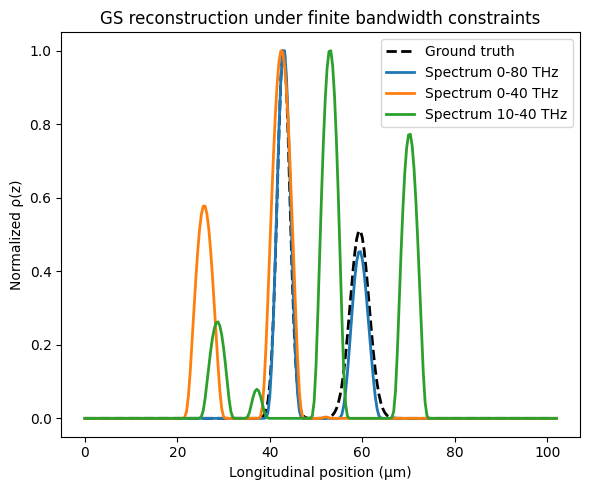

In [5]:
# Figure 4

# =========================================
# 1) Ground truth
# =========================================
rho_true_np = np.array(rho1, dtype=np.float64)
rho_true_np = np.clip(rho_true_np, 0, None)
rho_true_np = rho_true_np / np.sum(rho_true_np)
rho_true = torch.tensor(rho_true_np, dtype=torch.float32, device=device)

# =========================================
# 2) Compute full spectrum
# =========================================
I_full, _ = forward_spectrum_fft(rho_true)
I_full = I_full.real
I_full = I_full / torch.max(I_full)

# ---- build frequency axis ----
N = len(I_full)
dx = x_um[1] - x_um[0]
k = np.fft.fftfreq(N, d=dx) * 2*np.pi
freq = (3e8 * (k * 1e6) / (2*np.pi)) / 1e12  # THz
freq = torch.tensor(freq, dtype=torch.float32, device=device)

# =========================================
# 3) Support mask (fixed)
# =========================================
center = np.mean(x_um)
mask = (np.abs(x_um - center) <= 60/2).astype(np.float32)
support_mask = torch.tensor(mask, dtype=torch.float32, device=device)

# =========================================
# 4) Define band limits
# =========================================
band_cases = [
    (0, 80),
    (0, 40),
    (10, 40)
]

recon_results = []

for fmin, fmax in band_cases:
    if fmin == 0:
        band_mask = (freq >= 1) & (freq <= fmax)
        band_mask = band_mask.float()
    # Create band-limited spectrum
    else: 
        band_mask = (freq >= fmin) & (freq <= fmax)
        band_mask = band_mask.float()

    I_band = I_full * band_mask

    # Normalize inside band
    if torch.max(I_band) > 0:
        I_band = I_band / torch.max(I_band)

    torch.manual_seed(1)  # same initialization

    rho_rec = gerchberg_saxton_1d_torch(
        I_meas=I_band,
        n_iters=2000,
        support_mask=support_mask,
        smooth=True,
        device=device,
    )

    r = rho_rec.detach().cpu().numpy()
    r = np.clip(r, 0, None)
    r = r / r.max() if r.max() > 0 else r

    recon_results.append(((fmin, fmax), r))

# =========================================
# 5) Plot
# =========================================
plt.figure(figsize=(6,5))

# Ground truth
plt.plot(
    x_um,
    rho_true_np / rho_true_np.max(),
    "k--",
    linewidth=2,
    label="Ground truth"
)

# Reconstructions
for (fmin, fmax), r in recon_results:
    plt.plot(
        x_um,
        r,
        linewidth=2,
        label=f"Spectrum {fmin}-{fmax} THz"
    )

plt.xlabel("Longitudinal position (μm)")
plt.ylabel("Normalized ρ(z)")
plt.title("GS reconstruction under finite bandwidth constraints")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


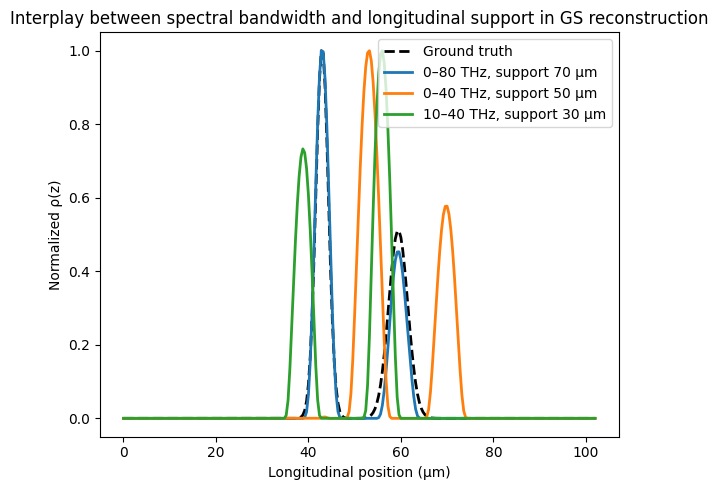

In [6]:
# Figure 5

# =========================================
# 1) Ground truth
# =========================================
rho_true_np = np.array(rho1, dtype=np.float64)
rho_true_np = np.clip(rho_true_np, 0, None)
rho_true_np = rho_true_np / np.sum(rho_true_np)
rho_true = torch.tensor(rho_true_np, dtype=torch.float32, device=device)

# =========================================
# 2) Compute full spectrum
# =========================================
I_full, _ = forward_spectrum_fft(rho_true)
I_full = I_full.real
I_full = I_full / torch.max(I_full)

N = len(I_full)
dx = x_um[1] - x_um[0]
k = np.fft.fftfreq(N, d=dx) * 2*np.pi
freq = (3e8 * (k * 1e6) / (2*np.pi)) / 1e12
freq = torch.tensor(freq, dtype=torch.float32, device=device)

# =========================================
# 3) Define three combined cases
# =========================================
cases = [
    {"band": (0, 80),  "support": 70,  "label": "0–80 THz, support 70 μm"},
    {"band": (0, 40), "support": 50,  "label": "0–40 THz, support 50 μm"},
    {"band": (10, 40), "support": 30, "label": "10–40 THz, support 30 μm"},
]

recon_results = []

for case in cases:

    fmin, fmax = case["band"]
    width = case["support"]

    # ---- Band limit ----
    if fmin == 0:
        band_mask = ((freq >= 1) & (freq <= fmax)).float()
    else:
        band_mask = ((freq >= fmin) & (freq <= fmax)).float()
    I_band = I_full * band_mask
    if torch.max(I_band) > 0:
        I_band = I_band / torch.max(I_band)

    # ---- Support mask ----
    center = np.mean(x_um)
    mask = (np.abs(x_um - center) <= width/2).astype(np.float32)
    support_mask = torch.tensor(mask, dtype=torch.float32, device=device)

    torch.manual_seed(1)

    rho_rec = gerchberg_saxton_1d_torch(
        I_meas=I_band,
        n_iters=2000,
        support_mask=support_mask,
        smooth=True,
        device=device,
    )

    r = rho_rec.detach().cpu().numpy()
    r = np.clip(r, 0, None)
    r = r / r.max() if r.max() > 0 else r

    recon_results.append((case["label"], r))

# =========================================
# 4) Plot
# =========================================
plt.figure(figsize=(6,5))

plt.plot(
    x_um,
    rho_true_np / rho_true_np.max(),
    "k--",
    linewidth=2,
    label="Ground truth"
)

for label, r in recon_results:
    plt.plot(
        x_um,
        r,
        linewidth=2,
        label=label
    )

plt.xlabel("Longitudinal position (μm)")
plt.ylabel("Normalized ρ(z)")
plt.title("Interplay between spectral bandwidth and longitudinal support in GS reconstruction")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()
